### LoRA Based Fine-Tuning of Qwen 2.5 for Time-Series Forecasting 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [2]:
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

In [3]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


##### Need to find which axes are of prey (0) and predator (1)

In [4]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]
print(time_data.shape, data_prey.shape, data_pred.shape)

(100,) (1000, 100) (1000, 100)


#### Evolution

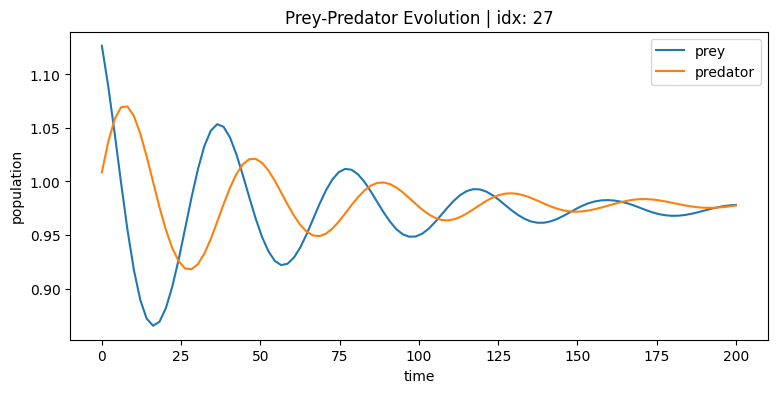

In [5]:
rn = random.randint(0, len(data_prey))

fig = plt.figure(figsize=(9, 4))

plt.plot(time_data, data_prey[rn], label = 'prey')
plt.plot(time_data, data_pred[rn], label = 'predator')
plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {rn}')
plt.show()

#### Qwen 2.5 (Untrained) - Zero Shot Forecasting

Qwen's Interfacing

```
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

```

In [ ]:
from utils.qwen import load_qwen

ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

##### LLMTIME preprocessing scheme (tokenize time-series data for Qwen instruct model)

In [38]:
import utils.preprocess
importlib.reload(utils.preprocess)
from utils.preprocess import ts_encoding, ts_decoding

In [13]:
check_rn = random.randint(0, len(data_prey))

In [39]:
tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------GPT-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

print()
print()

tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------LLAMA-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

Offset:  -3.1055586 Scale-Factor:  16.832659
Offset:  -0.32742453 Scale-Factor:  1.4627423
----------GPT-Encoding-------------
Input:  [[0.94991744 0.74055135 0.6822457  ... 2.3228664  2.3574128  2.347119  ]
 [0.9714744  1.0787003  1.260828   ... 2.4988842  2.4662724  2.4367042 ]
 [1.0732226  0.8540631  0.7681343  ... 2.3229585  2.3230035  2.3240573 ]
 ...
 [1.1288372  1.025194   0.9859951  ... 0.48976815 0.6844779  0.9849731 ]
 [1.1316459  0.80084616 0.6483697  ... 0.70776564 0.7266514  0.7947279 ]
 [1.0202591  0.76560074 0.6272315  ... 1.0364599  1.1292115  1.2237015 ]]
Tokenized:  0 . 2 3 5, 0 . 2 3 1, 0 . 2 3 2, 0 . 2 3 7, 0 . 2 4 5, 0 . 2 5 6, 0 . 2 7 0, 0 . 2 8 7, 0 . 3 0 7, 0 . 3 3 1, 0 . 3 6 0, 0 . 3 9 2, 0 . 4 2 9, 0 . 4 6 9, 0 . 5 1 2, 0 . 5 5 8, 0 . 6 0 5, 0 . 6 5 3, 0 . 6 9 9, 0 . 7 4 3, 0 . 7 8 5, 0 . 8 2 2, 0 . 8 5 6, 0 . 8 8 6, 0 . 9 1 1, 0 . 9 3 3, 0 . 9 5 0, 0 . 9 6 5, 0 . 9 7 7, 0 . 9 8 6, 0 . 9 9 2, 0 . 9 9 7, 1 . 0 0 0, 1 . 0 0 1, 1 . 0 0 0, 0 . 9 9 8, 0 . 9 9 3, 0 

### Shouldn't we jointly train prey and predator population <-- Since they are correlated 

In [ ]:
text = 'Hello! How are you doing!'

In [34]:
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

ft = time.time()
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=1
)
lt = time.time()

print('time-taken for inferencing: ', (lt - ft)/60)

generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


time-taken for inferencing:  0.22560700178146362


##### Seperated Inferencing

In [42]:
print('tokenized-prey: ', tokenized_prey)

model_inputs = tokenizer([tokenized_prey], return_tensors="pt").to(model.device) ## wrapped tokenization

ft = time.time()
predicted_tokenized = model.generate(
    **model_inputs,
    max_new_tokens=128
)
lt = time.time()

print('time-taken for inferencing: ', (lt - ft) / 60)

generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(' ---- Response ---- ')
pprint(response)

decoded_response = ts_decoding(response, model_type="llama", offset=offset_prey, scale_factor=scale_prey)

print()
print(' ---- Decoded-Response ---- ')
pprint(decoded_response)


tokenized-prey:  0.235, 0.231, 0.232, 0.237, 0.245, 0.256, 0.270, 0.287, 0.307, 0.331, 0.360, 0.392, 0.429, 0.469, 0.512, 0.558, 0.605, 0.653, 0.699, 0.743, 0.785, 0.822, 0.856, 0.886, 0.911, 0.933, 0.950, 0.965, 0.977, 0.986, 0.992, 0.997, 1.000, 1.001, 1.000, 0.998, 0.993, 0.988, 0.980, 0.970, 0.958, 0.944, 0.927, 0.907, 0.885, 0.859, 0.829, 0.796, 0.761, 0.723, 0.683, 0.643, 0.604, 0.568, 0.535, 0.508, 0.486, 0.470, 0.460, 0.456, 0.456, 0.461, 0.469, 0.481, 0.496, 0.513, 0.532, 0.552, 0.573, 0.594, 0.614, 0.634, 0.652, 0.669, 0.683, 0.695, 0.704, 0.710, 0.712, 0.712, 0.709, 0.703, 0.694, 0.683, 0.670, 0.656, 0.640, 0.623, 0.606, 0.590, 0.575, 0.561, 0.549, 0.540, 0.533, 0.528, 0.525, 0.525, 0.528, 0.532
time-taken for inferencing:  0.6132856567700704
 ---- Response ---- 
''


ValueError: could not convert string to float: ''